In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image = cv.imread('soduku.png')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
normal_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)


(551, 545)


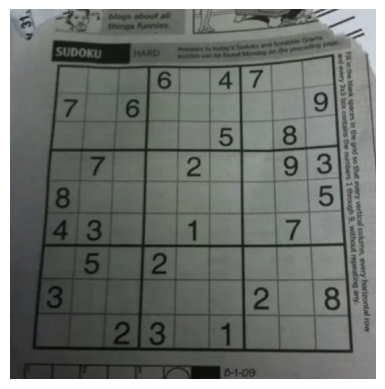

In [3]:
print(gray.shape)
plt.imshow(normal_image)
plt.axis('off')  
plt.show()

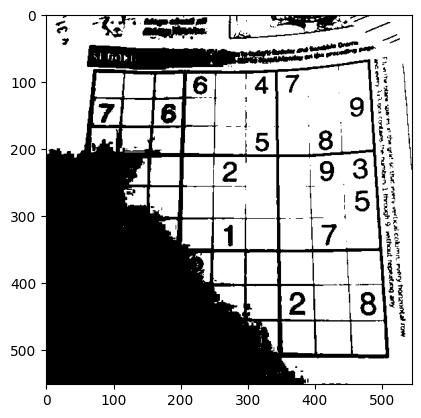

In [4]:
ret2,th2 = cv.threshold(gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(th2, cmap="gray")

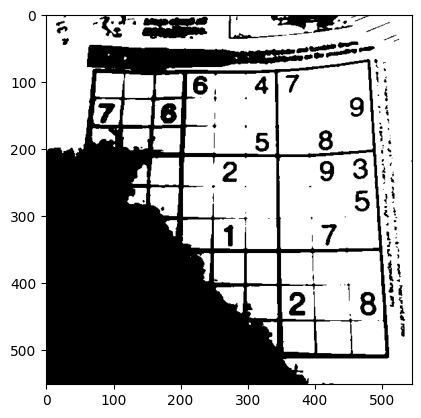

In [5]:
blur = cv.GaussianBlur(gray,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_OTSU)

plt.imshow(th3,cmap='gray')

In [6]:
edges = cv.Canny(gray, 10, 100)

In [7]:
cv.imshow("Edges", edges)
cv.waitKey(0)
cv.destroyAllWindows()

In [8]:
contours, hierarchy = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(image, contours, -1, (0, 255, 0), 2)

array([[[180, 173, 168],
        [180, 173, 168],
        [180, 173, 168],
        ...,
        [214, 207, 201],
        [214, 207, 201],
        [214, 207, 201]],

       [[178, 171, 165],
        [178, 171, 165],
        [178, 171, 165],
        ...,
        [214, 207, 201],
        [214, 207, 201],
        [214, 207, 201]],

       [[175, 168, 162],
        [175, 168, 162],
        [176, 168, 163],
        ...,
        [214, 207, 201],
        [214, 207, 201],
        [214, 207, 201]],

       ...,

       [[ 43,  46,  45],
        [ 43,  46,  45],
        [ 43,  46,  45],
        ...,
        [135, 132, 133],
        [135, 133, 133],
        [136, 134, 134]],

       [[ 43,  46,  45],
        [ 43,  46,  45],
        [ 43,  46,  45],
        ...,
        [135, 132, 133],
        [135, 133, 133],
        [136, 134, 134]],

       [[ 43,  46,  45],
        [ 43,  46,  45],
        [ 43,  46,  45],
        ...,
        [135, 132, 133],
        [135, 133, 133],
        [136, 134, 134]]

In [9]:
cv.imshow("Contours", image)
cv.waitKey(0)
cv.destroyAllWindows()

In [10]:
biggest_contour = max(contours, key=cv.contourArea)
cv.drawContours(image, [biggest_contour], -1, (255, 0, 0), 5)
cv.imshow("Contours", image)
cv.waitKey(0)
cv.destroyAllWindows()


In [11]:
contour_points = biggest_contour[:, 0, :].tolist()

max_x = max(contour_points, key=lambda x: x[0])[0]
min_x = min(contour_points, key=lambda x: x[0])[0]
max_y = max(contour_points, key=lambda x: x[1])[1]
min_y = min(contour_points, key=lambda x: x[1])[1]
p1 = (min_x, min_y)
p2 = (max_x, min_y)
p3 = (max_x, max_y)
p4 = (min_x, max_y)


In [12]:

cv.rectangle(image, p1, p3, (0, 0, 255), 4)  # Green color, thickness=2

cv.imshow("Rectangle", image)
cv.waitKey(0)
cv.destroyAllWindows()


In [ ]:
epsilon = 0.02 * cv.arcLength(biggest_contour, True)  
approx = cv.approxPolyDP(biggest_contour, epsilon, True)

if len(approx) == 4:
    rectangle_points = approx.reshape(4, 2)
    print("Rectangle Corner Points:", rectangle_points)

    for i in range(4):
        cv.line(image, tuple(rectangle_points[i]), tuple(rectangle_points[(i+1) % 4]), (0, 255, 0), 2)

    cv.imshow("Rectangle Approximation", image)
    cv.waitKey(0)
    cv.destroyAllWindows()
else:
    print("The contour is not a perfect rectangle.")

Rectangle Corner Points: [[482  67]
 [ 70  83]
 [ 34 506]
 [510 511]]


In [17]:
image = cv.imread('soduku.png')
for i in range(4):
    cv.line(image, tuple(rectangle_points[i]), tuple(rectangle_points[(i+1) % 4]), (0, 255, 0), 2)
cv.imshow("Rectangle Approximation", image)
cv.waitKey(0)
cv.destroyAllWindows()



In [20]:
rectangle_points = sorted(rectangle_points, key=lambda x: (x[1], x[0]))
if rectangle_points[0][0] > rectangle_points[1][0]:  # Swap top-left and top-right if needed
    rectangle_points[0], rectangle_points[1] = rectangle_points[1], rectangle_points[0]
if rectangle_points[2][0] < rectangle_points[3][0]:  # Swap bottom-left and bottom-right if needed
    rectangle_points[2], rectangle_points[3] = rectangle_points[3], rectangle_points[2]

width = 450  
height = 450  
dst_points = np.array([
    [0, 0],        
    [width-1, 0],  
    [width-1, height-1], 
    [0, height-1] 
], dtype="float32")

M = cv.getPerspectiveTransform(np.float32(rectangle_points), dst_points)

warped = cv.warpPerspective(image, M, (width, height))
cv.imshow("Warped Perspective", warped)
cv.waitKey(0)
cv.destroyAllWindows()